In [1]:
import os
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt

from itertools import combinations
from collections import Counter

In [2]:
# Merge 12 months of sales data into a single file.

all_data = pd.DataFrame()

for filename in os.listdir('./Sales_Data/'):
    df=pd.read_csv('./Sales_Data/'+filename)
    all_data = pd.concat([all_data,df])
    
all_data.to_csv('all_data.csv', index=False)
    

In [3]:
# Read the data from concatenated file

all_data = pd.read_csv('all_data.csv')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [9]:
# Create pandas profile report and save in as a html file

pp.ProfileReport(all_data).to_file('profile_report.html')

C:\Users\Madhulika\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0
  'bottom=%s, top=%s') % (bottom, top))


### Data Cleaning

From the above report generated, it can be seen that the data needs to be cleaned.

- Remove duplicate data
- Remove rows of data, whose values are identical to the rows names
- Modify the data types of columns
- Handle missing values
- Rename the columns to avoid spaces in the names of columns

In [4]:
# Remove duplicate data
all_data.drop_duplicates(inplace=True)

# Rename the column names
all_data.columns = all_data.columns.str.replace(' ', '_')

# Remove rows with values same as column labels
all_data = all_data[all_data.Order_ID != 'Order ID']

# Drop missing values
all_data = all_data.dropna()

# Modify column dtypes
convert_dict = {'Quantity_Ordered': int, 'Price_Each':float}

all_data = all_data.astype(convert_dict)
all_data['Order_ID'] = pd.Categorical(all_data.Order_ID)
all_data['Order_Date'] = pd.to_datetime(all_data['Order_Date'])

In [5]:
# Write cleaned data to a separate file

all_data.to_csv('Sales_Data_Cleaned.csv', index=False)

In [6]:
all_data = pd.read_csv('Sales_Data_Cleaned.csv')

### Data Exploration

1. What was the best month for sales? How much was earned that month?
2. What city sold the most product?
3. What time should we display advertisemens to maximize the likelihood of customer’s buying product?
4. What products are most often sold together?
5. What product sold the most? Why do you think it sold the most?

### 1. What was the best month for sales? How much was earned that month?


In [7]:
# Extract month and year from Order_Date.
all_data['Year'] = pd.DatetimeIndex(all_data['Order_Date']).year
all_data['Month'] = pd.DatetimeIndex(all_data['Order_Date']).month

# Add sales column
all_data['Sales'] = all_data['Quantity_Ordered'] * all_data['Price_Each']


sales_by_month = all_data.groupby(['Month'])['Quantity_Ordered', 'Price_Each', 'Sales'].sum()

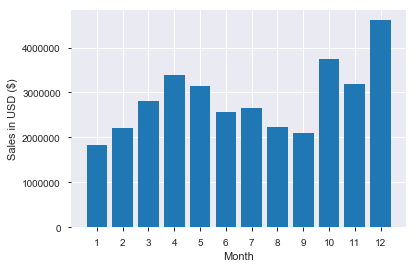

In [22]:
# Plot sales by month

months = range(1,13)


plt.bar(months, sales_by_month['Sales'])
plt.xticks(months)
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month')
plt.show()


### Insights
From the above plot we can see that sales were higher in the month of December of about 4.6M. This probably is because December is festive season with christmas, Newyear's and purchases tend to increase during this month.

### 2. What city sold the most product?

In [23]:
# Extract city and state from Purchase_Address.

def get_city_state(address):
    address = address.split(',')
    return address[1] + '(' + address[2].split(' ')[1] + ')'


In [24]:
all_data['City'] = all_data['Purchase_Address'].apply(lambda x: get_city_state(x))

sales_by_city = all_data.groupby('City')['Quantity_Ordered', 'Price_Each', 'Sales'].sum()

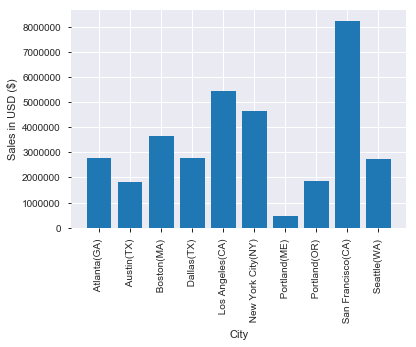

In [27]:
cities = [city for city, df in all_data.groupby('City')]

plt.bar(cities, sales_by_city['Sales'])
plt.xticks(cities, rotation='vertical', size=10)
plt.ylabel('Sales in USD ($)')
plt.xlabel('City')
plt.show()


### Insights

From the above graph, we can see that San Francisco city has the maximum number of purchases. This could be because of higher number of tech companies in SF and this tend to increase the personal and commercial purchases of tech products in this city.

### 3.What time should we display advertisements to maximize the likelihood of customer’s buying product?

In [29]:
# Extract hours from time in Order_Date

all_data['Hours'] = all_data['Order_Date'].dt.hour

sales_by_hours = all_data.groupby('Hours')['Quantity_Ordered', 'Price_Each', 'Sales'].sum()

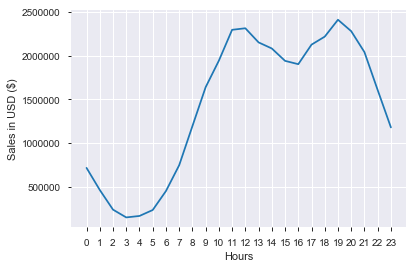

In [36]:
hours = [hour for hour, df in all_data.groupby('Hours')]

plt.plot(hours, sales_by_hours['Sales'])
plt.xticks(hours)
plt.ylabel('Sales in USD ($)')
plt.xlabel('Hours')
plt.show()

### Insight

Purchases tend to increase during midday at around 11AM and again in the evening at around 7PM. So, displaying advertisements from half an hour before these trending timings will likely increase the sales further.

### 4. What products are most often sold together?

In [61]:
# Extract products bought together using Order_ID

sales_by_products_groups = all_data[all_data['Order_ID'].duplicated(keep=False)]
sales_by_products_groups['Grouped'] = sales_by_products_groups.groupby('Order_ID')['Product'].transform(lambda x: ','.join(x))

# Remove duplicated combinations
sales_by_products_groups = sales_by_products_groups[['Order_ID', 'Grouped']].drop_duplicates()

C:\Users\Madhulika\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [63]:
# Count the number of times product groups are bought.

count = Counter()

for row in sales_by_products_groups['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

# Get 10 most commonly purchased product combinations.
count.most_common(10)


[(('iPhone', 'Lightning Charging Cable'), 1002),
 (('Google Phone', 'USB-C Charging Cable'), 985),
 (('iPhone', 'Wired Headphones'), 447),
 (('Google Phone', 'Wired Headphones'), 413),
 (('Vareebadd Phone', 'USB-C Charging Cable'), 361),
 (('iPhone', 'Apple Airpods Headphones'), 360),
 (('Google Phone', 'Bose SoundSport Headphones'), 220),
 (('USB-C Charging Cable', 'Wired Headphones'), 159),
 (('Vareebadd Phone', 'Wired Headphones'), 143),
 (('Lightning Charging Cable', 'Wired Headphones'), 92)]

### Insight:

From the above derived list, we can observe that phones are bought together with either their corresponding charging cables or wired headphones.

### 5. What product sold the most? Why do you think it sold the most?

In [8]:
all_data.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Year,Month,Sales
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",2019,4,23.90
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",2019,4,99.99
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019,4,600.00
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019,4,11.99
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",2019,4,11.99


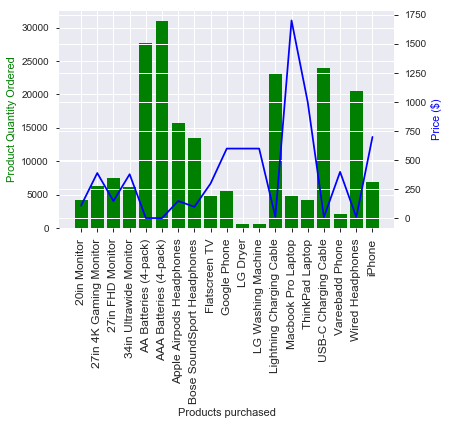

In [13]:
sales_by_products = all_data.groupby('Product')['Quantity_Ordered', 'Sales'].sum()
prices = all_data.groupby('Product').mean()['Price_Each']
products = [products for products, df in all_data.groupby('Product')]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, sales_by_products['Quantity_Ordered'], color='g')
ax2.plot(products, prices, 'b')

ax1.set_xticklabels(products, rotation='vertical', size=12)
ax1.set_ylabel('Product Quantity Ordered', color='g')
ax2.set_ylabel('Price ($)', color='b')
ax1.set_xlabel('Products purchased')

plt.show()

### Insight

From the above analysis, we can deduce that AAA and AA batteries have sold the most and these products have low prices than the other products. So, we can see that the products with cheaper prices have the maximum sales.